# 必要なライブラリのインポート

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential, load_model
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import matplotlib.pyplot as plt

2023-06-01 05:21:46.966416: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# モデルの構築
Sequential()はSequential APIを使ってモデルを初期化します。Sequential APIはレイヤーを一列に積み重ねる最もシンプルなモデル構築方法です。

## レイヤー
- Dense: これは通常の全結合ニューラルネットワークのレイヤーで、各入力ノードが各出力ノードに接続しています。これはtf.keras.layers.Dense(units, activation)という形で使用されます。ここで、unitsは出力空間の次元（すなわち、レイヤーのニューロン数）を指定し、activationは使用する活性化関数を指定します。
- Conv2D: これは畳み込みニューラルネットワーク（CNN）のレイヤーで、画像の局所的な特徴を捉えるために使用されます。これはtf.keras.layers.Conv2D(filters, kernel_size, activation)という形で使用されます。ここで、filtersは出力空間の次元（つまり、畳み込みによって生成されるフィルターの数）、kernel_sizeは畳み込みのウィンドウサイズを指定します。
- MaxPooling2D: これもCNNの一部で、画像データの次元を削減し、重要な特徴を保持するために使用されます。これはtf.keras.layers.MaxPooling2D(pool_size)という形で使用されます。ここで、pool_sizeはプーリングウィンドウのサイズを指定します。
- Dropout: これは過学習を防ぐためのレイヤーで、訓練中にランダムに入力ユニットをドロップアウト（つまり、0に設定）します。これはtf.keras.layers.Dropout(rate)という形で使用されます。ここで、rateはドロップアウトさせる入力の割合を指定します。
- Flatten: これは多次元のテンソルを1次元に変換します。CNNの後に全結合層を追加する前にしばしば使用されます。

## 活性化関数
- ReLU: 負の入力は0として、0もしくは正の入力はそのまま出力する関数(つまりmax(0, x))
- softmax: 合計が1になるように，ベクトル中の各次元の変数を正規化する関数

In [2]:
# パラメータ
vocab_size = 6000
embedding_dim = 128
max_length = 130

model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(GRU(32, return_sequences = True)),
    GlobalMaxPool1D(),
    Dense(20, activation="relu"),
    Dropout(0.05),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

2023-06-01 05:21:50.735113: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-01 05:21:50.808184: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-01 05:21:50.808491: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-01 05:21:50.812345: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-01 05:21:50.812692: I tensorflow/compile

# モデルの内容を確認

- 最初の行のconv2dは28x28のデータを3x3のフィルタでストライド（何マスずらすか）が1なので26x26の二次元配列が32フィルタ分出力される。
- conv2dのParam数は`入力のチャネル数 * フィルタの高さ * フィルタの幅 * フィルタの数 + フィルタの数`(1 * 3 * 3 * 32 + 32 = 320)となる。
- flattenは多次元のテンソルを1次元に変換するので各次元の要素数の積(12 * 12 * 64 = 9216)のテンソルが出力される。
- denseのParam数は各入力ノードが各出力ノードに接続されるので`入力ノード数 * 出力ノード数 + 出力ノード数` (9216 * 128 + 128 = 1179776, 128 * 10 + 10 = 1290)となる。

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 130, 128)          768000    
                                                                 
 bidirectional (Bidirectiona  (None, 130, 64)          31104     
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 20)                1300      
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2

# 学習データをロードする関数の作成

In [9]:
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def load_data():
    # データのロード
    (train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=vocab_size)
    # パディング
    train_data = pad_sequences(train_data, maxlen=max_length)
    test_data = pad_sequences(test_data, maxlen=max_length)
    return (train_data, train_labels), (test_data, test_labels)

def decoded_review(vector):
    return ' '.join([reverse_word_index.get(i - 3, '_') for i in vector])

(x_train, y_train), (x_test, y_test) = load_data()
print(len(x_train), len(x_test))
print(x_train[0])

25000 25000
[  62  386   12    8  316    8  106    5    4 2223 5244   16  480   66
 3785   33    4  130   12   16   38  619    5   25  124   51   36  135
   48   25 1415   33    6   22   12  215   28   77   52    5   14  407
   16   82    2    8    4  107  117 5952   15  256    4    2    7 3766
    5  723   36   71   43  530  476   26  400  317   46    7    4    2
 1029   13  104   88    4  381   15  297   98   32 2071   56   26  141
    6  194    2   18    4  226   22   21  134  476   26  480    5  144
   30 5535   18   51   36   28  224   92   25  104    4  226   65   16
   38 1334   88   12   16  283    5   16 4472  113  103   32   15   16
 5345   19  178   32]


# モデルの訓練

Epoch 1/3


2023-06-01 05:21:59.083738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-01 05:21:59.086154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-01 05:21:59.087536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

200/200 [==============================] - ETA: 0s - loss: 0.4699 - accuracy: 0.7862

2023-06-01 05:22:32.095615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-01 05:22:32.097119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-01 05:22:32.098193: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

200/200 [==============================] - 34s 143ms/step - loss: 0.4699 - accuracy: 0.7862 - val_loss: 0.3281 - val_accuracy: 0.8596
Epoch 2/3
200/200 [==============================] - 15s 76ms/step - loss: 0.2660 - accuracy: 0.8917 - val_loss: 0.3204 - val_accuracy: 0.8630
Epoch 3/3
200/200 [==============================] - 10s 50ms/step - loss: 0.1971 - accuracy: 0.9236 - val_loss: 0.3389 - val_accuracy: 0.8602


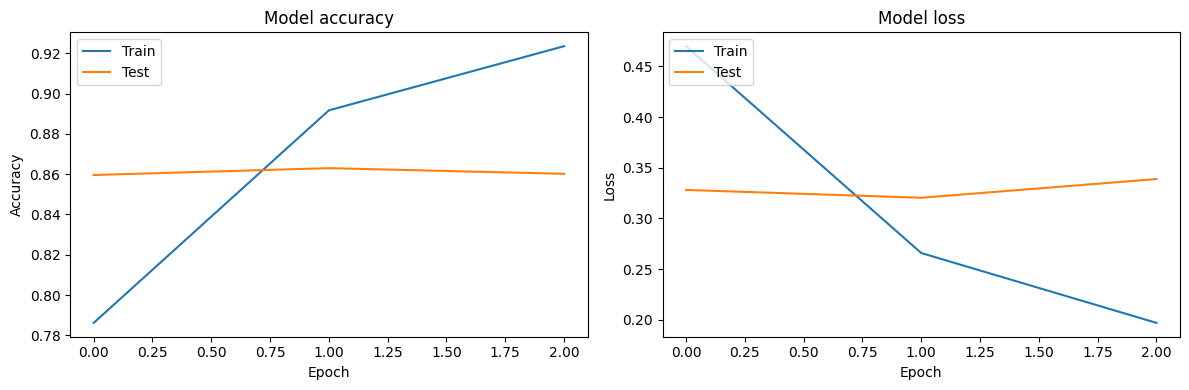

In [5]:
history = model.fit(x_train, y_train, batch_size=100, epochs=3, verbose=1, validation_split=0.2)
model.save('imdb_model.h5')

# 精度の学習曲線
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# 損失の学習曲線
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

# 動作確認

In [6]:
model = load_model('imdb_model.h5')
y_pred = model.predict(x_test)

2023-06-01 05:22:59.402118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-01 05:22:59.404314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-01 05:22:59.405770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

782/782 [==============================] - 13s 16ms/step


In [7]:
results = np.array([(decoded_review(x_test[i]).strip(), y_test[i], f"{pred[0]:.3f}") for i, pred in enumerate(y_pred[:100])])
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
df = pd.DataFrame(results, columns=['text', 'expected', 'pred'])
df

,text,expected,pred
0,_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ please give this one a miss br br _ _ and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael _ could have allowed this one on his _ he almost seemed to know this wasn't going to work out and his performance was quite _ so all you _ fans give this a miss,0,0.092
1,the _ young man regular altman player michael murphy has a small part the _ moody set fits the content of the story very well in short this movie is a powerful study of loneliness sexual _ and desperation be patient _ up the atmosphere and pay attention to the wonderfully written script br br i praise robert altman this is one of his many films that deals with _ fascinating subject matter this film is disturbing but it's sincere and it's sure to _ a strong emotional response from the viewer if you want to see an unusual film some might even say bizarre this is worth the time br br unfortunately it's very difficult to find in video stores you may have to buy it off the internet,1,0.987
2,let well enough alone br br considering the time period when this _ little film was made and considering the fact that it was made by a russian _ at the height of that _ _ civil war it would be easy to see this as a _ about those events _ may or may not have had _ _ in mind when he made _ but whatever _ his choice of material the film stands as a _ tale of universal _ _ could be the soviet union italy germany or japan in the 1930s or any country of any era that lets its guard down and is _ by _ it's a fascinating film even a charming one in its _ way but its message is no joke,1,0.754
3,idiots i am a grown man pretty big and i can defend myself well however i would not do half the stuff the little girl does in this movie also the mother in this movie is _ with her children to the point of _ i wish i wasn't so angry about her and her actions because i would have otherwise enjoyed the flick what a number she was take my advise and fast forward through everything you see her do until the end also is anyone else getting sick of watching movies that are filmed so dark anymore one can hardly see what is being filmed as an audience we are _ involved with the actions on the screen so then why the hell can't we have night vision,0,0.283
4,_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ like some other people wrote i'm a die hard mario fan and i loved this game br br this game starts slightly boring but trust me it's worth it as soon as you start your hooked the levels are fun and _ they will hook you _ your mind turns to _ i'm not kidding this game is also _ and is beautifully done br br to keep this spoiler free i have to keep my mouth shut about details but please try this game it'll be worth it br br story 9 9 action 10 1 it's that good _ 10 attention _ 10 average 10,1,0.995
5,absolutely disgusted this movie isn't being sold all who love this movie should _ disney and _ the demand for it they'd eventually have to sell it then i'd buy copies for everybody i know everything and everybody in this movie did a good job and i haven't figured out why disney hasn't put this movie on dvd or on vhs in rental stores at least i haven't seen any copies this is a wicked good movie and should be seen by all the kids in the new generation don't get to see it and i think they should it should at least be put back on the channel this movie doesn't deserve a cheap _ it deserves the real thing i'm them now this movie will be on dvd,1,0.794
6,and gives a lasting impression of the horror of the _ _ br br the death of a young mother leads to a baby _ _ down the steps in a sequence that has been _ by hitchcock in foreign _ by terry _ in brazil and brian _ in the _ this sequence is shown repeatedly from various angles thus drawing out what probably was only a five second event br br _ is a film that the revolutiona